In [1]:
import os
import json
import numpy as np
import pandas as pd
import shutil
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image

from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

In [25]:
IMAGE_SIZE = 380
PATH = "/app/_data/"
IMG_PATH = "/app/_data/train_images/"
MODEL_PATH = '/app/_data/models/new/bond_box_999_200.h5'
DF_PATH = '../_data/df_csv/df_boxes_colab.csv'
TARGET_IMG_PATH = 'app/_data/cropped_all_380_2/'

# crop + resize

In [9]:
df_crop = pd.read_csv(DF_PATH)
df_crop.columns = ['image', 'x_min', 'y_min', 'x_max', 'y_max']

In [10]:
df_crop

,image,x_min,y_min,x_max,y_max
0,bfc6d90f402f4c34.jpg,0.168664,0.147781,0.769752,0.896313
1,9eb93fe282326266.jpg,0.188170,0.403469,0.792868,0.818566
2,f4cb3a8f41b413e4.jpg,0.066045,0.078917,0.813638,0.931608
3,98322eab16bef2c1.jpg,0.213681,0.308594,0.765903,0.938598
4,dad5d6250cae80b7.jpg,0.009096,0.232706,0.856984,0.925184
...,...,...,...,...,...
22269,Test_1140.jpg,0.082660,0.224326,0.790734,0.938389
22270,Test_606.jpg,0.333407,0.360054,0.687298,0.749096
22271,Train_701.jpg,0.128120,0.017819,0.961691,0.984454
22272,Train_395.jpg,0.092582,0.128696,0.959880,0.958929


In [34]:
def write_np(file_path, df):
    img = tf.io.read_file(IMG_PATH+ file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    coord = df[df["image"] == file_path][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
    orig_hight = img.shape[0]
    orig_width = img.shape[1]
    x_min = coord[0]
    y_min = coord[1]
    x_max = coord[2]
    y_max = coord[3]
    cropped_image = img.numpy()[np.int(y_min*orig_hight):np.int(y_max*orig_hight),np.int(x_min*orig_width):np.int(x_max*orig_width)]
    img = tf.image.resize(cropped_image, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img, dtype='uint8')
    img = Image.fromarray(img.numpy())
    if not os.path.exists(TARGET_IMG_PATH):
        os.makedirs(TARGET_IMG_PATH)
    img.save(TARGET_IMG_PATH+file_path)
    return img
# # labels_21_20['image'].apply(write_np)
# all_imgs = os.listdir(PATH + 'train_images/')
# for i in tqdm(range(len(all_imgs))):
#     if all_imgs[i] in df_crop["image"].values:
#          write_np(all_imgs[i])

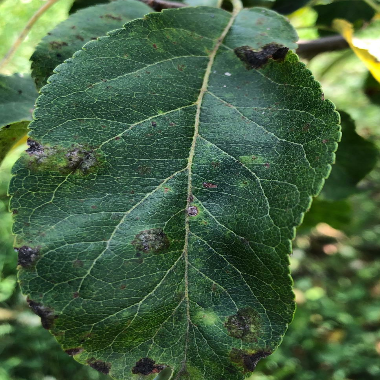

In [35]:
write_np('Test_1140.jpg', df_crop)

In [ ]:
os.makedirs()

In [ ]:
# def write_np(file_path):
#     img = tf.io.read_file(TRAIN_IMG_PATH + file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(
#         img,
#         IMAGE_SIZE,
#     )
#     img = tf.image.convert_image_dtype(img, tf.uint8)
# #     img = Image.fromarray(np.array(img))
#     if not os.path.exists(TARGET_IMG_PATH):
#         os.mkdir(TARGET_IMG_PATH)
#     img.save(PATH + '380/'+file_path)
#     return img
#     np.save(PATH + 'cache/'+file_path[:-4], img)
# labels['image'].apply(write_np)